In [1]:
import copy
from typing import Union

import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp, odeint
from scipy.optimize import minimize
import pandas as pd
import torch
import torch.nn as nn
from tqdm import tqdm

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set random seed for reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Do not use scientific notation
np.set_printoptions(suppress=True, linewidth=1000)
torch.set_printoptions(sci_mode=False, linewidth=1000)

In [2]:
#################################################################   
####################Physics-Informed Neural Network #############
NUM_EPOCHS = 50000
LEARNING_RATE = 1e-4
PATIENCE = 1000
THRESHOLD = 1e-3
EARLY_STOPPING_EPOCH = 1
NUM_COLLOCATION = 1000
NUM_SAMPLES = 1000

MU = 1.0

T_START = 0.0
T_END = 10.0
dt = 0.5

X1_MIN, X2_MIN = -3.0, -3.0
X1_MAX, X2_MAX = 3.0, 3.0
U_MIN, U_MAX = -1.0, 1.0

In [3]:
def plot_solution(df: pd.DataFrame) -> None:
    # Plot the solution
    plt.figure(figsize=(10, 3))
    plt.plot(df["t"], df["x1"], label="x1(t)")
    plt.plot(df["t"], df["x2"], label="x2(t)")
    ax2 = plt.gca().twinx()
    ax2.step(df["t"], df["u"], label="u(t)", color='gray', linestyle='--', alpha=0.5)
    ax2.set_ylabel("Control")
    ax2.legend(loc='upper right')
    plt.xlabel("Time")
    plt.ylabel("State")
    plt.xticks(np.arange(T_START, T_END + dt, dt))
    plt.title("Van der Pol Oscillator")
    plt.legend()
    plt.grid()
    plt.show()

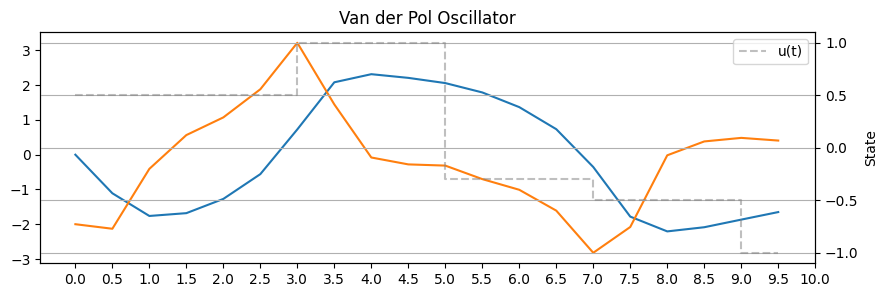

In [4]:
# Define a time-varying control input u(t) as a step function
def control_input(t):
    if t <= 3:
        return 0.5
    elif t <= 5:
        return 1.0
    elif t <= 7:
        return -0.3
    elif t <= 9:
        return -0.5
    else:
        return -1

# Van der Pol oscillator dynamic system with time-varying u
def vanderpol(t, x, mu=MU):
    u = control_input(t)
    return np.array([x[1], mu * (1 - x[0] ** 2) * x[1] - x[0] + u])

# Solve the system using solve_ivp
sol_varying_u = solve_ivp(
    fun=vanderpol, 
    t_span=(T_START, T_END), 
    y0=[0, -2], 
    args=(MU,), 
    method="RK45", 
    max_step=0.01,
    t_eval=np.arange(T_START, T_END, dt),
)

# Convert the solution to a DataFrame
df = pd.DataFrame(sol_varying_u.y.T, columns=["x1", "x2"])
df["t"] = sol_varying_u.t
df["u"] = df["t"].apply(control_input)

plot_solution(df)

In [5]:
def numpy_to_tensor(array):
    return torch.tensor(array, requires_grad=True, dtype=torch.float32).to(DEVICE).reshape(-1, 1)

def grad(outputs, inputs):
    return torch.autograd.grad(outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True)

class PINN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(PINN, self).__init__()
        self.input = nn.Linear(input_dim, 256)
        self.fc = nn.Linear(256, 256)
        self.output = nn.Linear(256, output_dim)

    def forward(self, x):
        x = torch.relu(self.input(x))
        x = torch.relu(self.fc(x))
        x = torch.relu(self.fc(x))
        x = self.output(x)
        return x

In [6]:
def generate_dataset(num_samples: int = NUM_SAMPLES):
    """Generate dataset of random multiple initial conditions and control actions"""
    df = pd.DataFrame(columns=['t', 'x1', 'x2', 'u'])
    df['x1'] = np.random.uniform(X1_MIN, X2_MAX, num_samples)
    df['x2'] = np.random.uniform(X2_MIN, X2_MAX, num_samples)
    df['u'] = np.random.uniform(U_MIN, U_MAX, num_samples)
    df['t'] = 0.0 # initial time (always 0)
    
    t_train = numpy_to_tensor(df['t'].values)
    X1_train = numpy_to_tensor(df['x1'].values)
    X2_train = numpy_to_tensor(df['x2'].values)
    U_train = numpy_to_tensor(df['u'].values)
    
    in_train = torch.cat([t_train, X1_train, X2_train, U_train], dim=1)
    out_train = torch.cat([X1_train, X2_train], dim=1)
    
    return in_train, out_train

def loss_fn(net: nn.Module) -> torch.Tensor:
    t_col = numpy_to_tensor(np.random.uniform(T_START, dt, NUM_COLLOCATION))
    X1_col = numpy_to_tensor(np.random.uniform(X1_MIN, X2_MAX, NUM_COLLOCATION))
    X2_col = numpy_to_tensor(np.random.uniform(X2_MIN, X2_MAX, NUM_COLLOCATION))
    U_COL = numpy_to_tensor(np.random.uniform(U_MIN, U_MAX, NUM_COLLOCATION))
    
    u_col = torch.cat([t_col, X1_col, X2_col, U_COL], dim=1)

    preds = net.forward(u_col)

    X1_pred = preds[:, 0].view(-1, 1)
    X2_pred = preds[:, 1].view(-1, 1)
    
    dX1dt_pred = grad(X1_pred, t_col)[0]
    dX2dt_pred = grad(X2_pred, t_col)[0]

    error_dX1dt = dX1dt_pred - X2_pred
    error_dX2dt = dX2dt_pred - MU * (1 - X1_pred ** 2) * X2_pred + X1_pred - U_COL
    
    error_ode = (torch.mean(error_dX1dt ** 2) + torch.mean(error_dX2dt ** 2)) / 2
    
    
    return error_ode

In [7]:
in_train, out_train = generate_dataset()

print(f'Input shape: {in_train.shape}')
print(f'Output shape: {out_train.shape}')

Input shape: torch.Size([1000, 4])
Output shape: torch.Size([1000, 2])


In [ ]:
# Main
net = PINN(input_dim=in_train.shape[1], output_dim=out_train.shape[1]).to(DEVICE)
optimizer = torch.optim.Adam(net.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2500, gamma=0.7)

# Loss weights
w_data, w_ode, w_ic = 1.0, 1.0, 1.0

# Initialize early stopping variables
best_loss = float("inf")
best_model_weights = None
patience = PATIENCE
threshold = THRESHOLD

for epoch in tqdm(range(NUM_EPOCHS)):
    optimizer.zero_grad()
    preds = net.forward(in_train)
    X1_pred = preds[:, 0].view(-1, 1)
    X2_pred = preds[:, 1].view(-1, 1)
    loss_data = torch.mean((torch.mean((X1_pred - out_train[:, 0].view(-1, 1))**2) + torch.mean((X2_pred - out_train[:, 1].view(-1, 1))**2)))
    loss_ode = loss_fn(net)
    loss = w_data * loss_data + w_ode * loss_ode
    loss.backward()
    optimizer.step()
    scheduler.step()
    
    if epoch % 1000 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.4e}, Data Loss = {loss_data.item():.4e}, ODE Loss = {loss_ode.item():.4e}")
        
    # Early stopping
    if loss.item() < best_loss - threshold:
        best_loss = loss.item()
        best_model_weights = copy.deepcopy(net.state_dict())
        patience = PATIENCE
    else:
        patience -= 1
        if patience <= 0:
            print(f"Early stopping at epoch {epoch}")
            break

# Load best model weights
if best_model_weights is not None:
    net.load_state_dict(best_model_weights)
    net.eval()
    print("Loaded best model weights.")
else:
    print("No model weights to load.")
    net.eval()

# Save the model
torch.save(net.state_dict(), 'pinn_model_paper.pth')

In [ ]:
T_s = 0.5
t_test = numpy_to_tensor(np.array([df['t'].values]))
x1_test = numpy_to_tensor(np.array([df['x1'].values]))
x2_test = numpy_to_tensor(np.array([df['x2'].values]))
u_test = numpy_to_tensor(np.array([df['u'].values]))
in_test = torch.cat([t_test, x1_test, x2_test, u_test], dim=1)
out_test = torch.cat([x1_test, x2_test], dim=1)

x1_0 = x1_test[0]
x2_0 = x2_test[0]
u_0 = u_test[0]

x1_preds = []
x2_preds = []

for i in range(len(df)):
    if i == 0:
        x1_preds.append(x1_0.item())
        x2_preds.append(x2_0.item())
        continue
    
    x_k = net.forward(torch.tensor([T_s, x1_0, x2_0, u_0], dtype=torch.float32).to(DEVICE))
    x1_0 = x1_test[i]
    x2_0 = x2_test[i]
    u_0 = u_test[i]
    x1_preds.append(x_k[0].item())
    x2_preds.append(x_k[1].item())
    

In [ ]:
plt.figure(figsize=(10, 5))
plt.scatter(df['t'], df['x1'], label="x1(t)", color='blue', s=10)
plt.scatter(df['t'], df['x2'], label="x2(t)", color='orange', s=10)

plt.plot(t_test.detach().cpu().numpy(), x1_preds, label="x1_pred(t)", color='blue', linestyle='--')
plt.plot(t_test.detach().cpu().numpy(), x2_preds, label="x2_pred(t)", color='orange', linestyle='--')



In [20]:
# MPC parameters
T_START, T_END = 0.0, 60.0  
TIME_RANGE = T_END - T_START
dt = 0.5                         # Time step
L = int(TIME_RANGE / dt)         # Simulation steps
N_p = 5                         # Prediction horizon
Q = 10                            # Weight for tracking
R = 1                          # Weight for control effort
Q_term = 0.0                     # Weight for terminal state
OPTIMIZATION_METHOD = 'SLSQP'    # Optimization method. Other options: 'SLSQP, 'L-BFGS-B', 'trust-constr', 'COBYLA', 'Powell', 'Nelder-Mead'
ODE_SOLVER = 'RK45'

BOUNDS = [(U_MIN, U_MAX) for _ in range(N_p)]  # Bounds for pedal position

print(f'Number of steps: {L} and dt: {dt}')

# Van der Pol oscillator dynamic system with time-varying u
def system_dynamics(t, x: float, u: float):
    return np.array([x[1], MU * (1 - x[0] ** 2) * x[1] - x[0] + u])

def solve_ode(ode: callable, t_span: list, y0: list, method: str, t_eval: list, args: tuple) -> solve_ivp:
    sol = solve_ivp(ode, t_span=t_span, y0=y0, method=method, args=args, t_eval=t_eval)
    return sol

Number of steps: 120 and dt: 0.5


In [21]:
def set_point(t):
    if t <= 15:
        return 0
    elif t <= 30:
        return -0.5
    elif t <= 45:
        return 0.5
    else:
        return 1

In [22]:
# ----- Cost function -----
def cost_function(u_opt: list, x1: float, x2: float, x_sp: float) -> float:
    J = 0
    for k in range(N_p):
        # x1_next, x2_next = net(torch.tensor([dt, x1, x2, u_opt[k]], dtype=torch.float32, device=DEVICE)).detach().cpu().numpy()
        sol = solve_ode(system_dynamics, t_span=[0, dt], y0=[x1, x2], method=ODE_SOLVER, t_eval=[dt], args=(u_opt[k],))      
        x1_next = sol.y[0][-1]
        x2_next = sol.y[1][-1]
        J += Q * (x_sp - x1_next) ** 2
        if k > 0:
            J += R * (u_opt[k] - u_opt[k - 1]) ** 2
        x1 = x1_next
        x2 = x2_next
    return J

In [23]:
x1 = np.zeros(L)
x2 = np.zeros(L)
x1[0] = 1.0
x2[0] = 0.0 
u = np.ones(L) * 0.5

for i in tqdm(range(L-1)):
    t = i * dt
    x_sp = set_point(t)
    res = minimize(cost_function, np.zeros(N_p), args=(x1[i], x2[i], x_sp), bounds=BOUNDS, method=OPTIMIZATION_METHOD)
    u_new = res.x[0]
    u[i + 1] = u_new
    sol = solve_ode(system_dynamics, t_span=[0, dt], y0=[x1[i], x2[i]], method=ODE_SOLVER, t_eval=[dt], args=(u_new,))
    x1[i + 1] = sol.y[0][-1]
    x2[i + 1] = sol.y[1][-1]

100%|██████████| 119/119 [00:04<00:00, 27.89it/s]


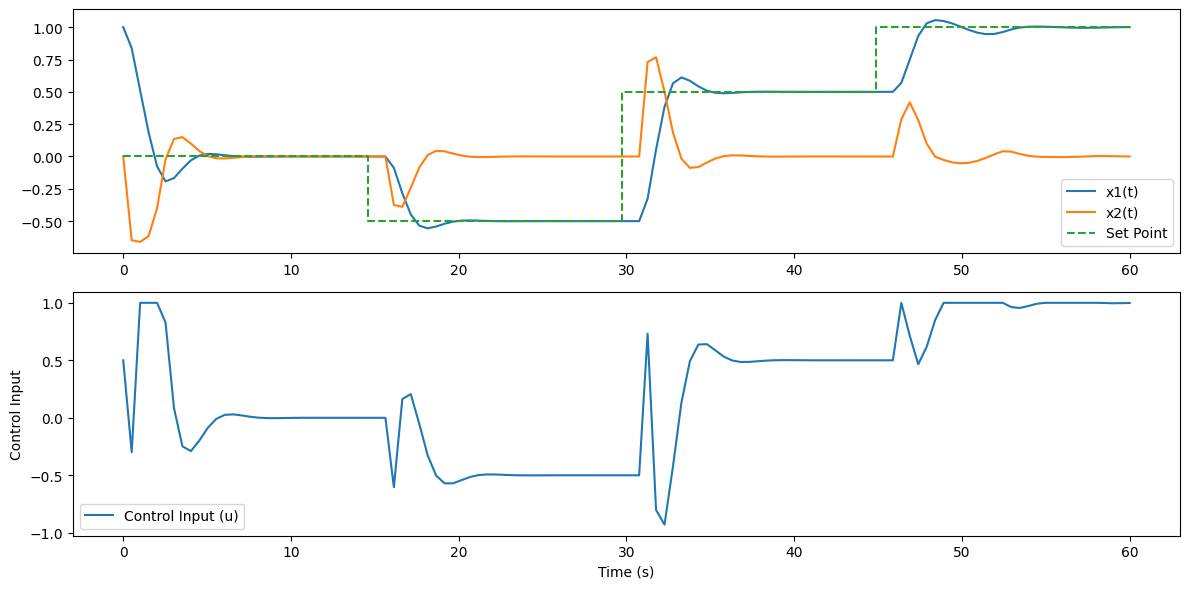

In [24]:
time = np.linspace(T_START, T_END, L)
plt.figure(figsize=(12, 6))
plt.subplot(2,1,1)
plt.plot(time, x1, label='x1(t)')
plt.plot(time, x2, label='x2(t)')
plt.step(time, [set_point(t) for t in time], label='Set Point', linestyle='--')
plt.legend()

plt.subplot(2,1,2)
plt.plot(time, u, label='Control Input (u)')
plt.xlabel('Time (s)')
plt.ylabel('Control Input')
plt.legend()
plt.tight_layout()
plt.show()


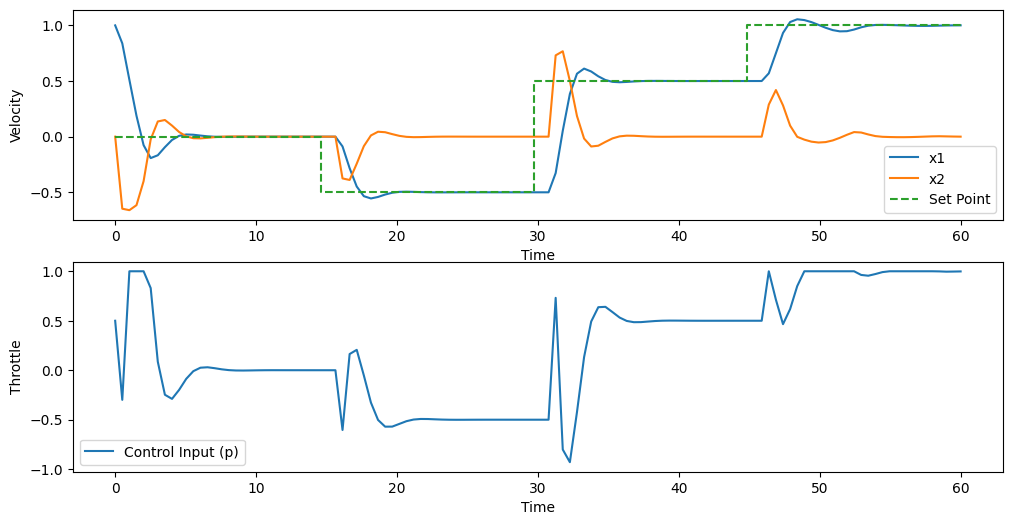

In [25]:
from scipy.interpolate import interp1d

# System dynamics
def simulate(t, x, u_func) -> float:
    u = u_func(t)
    dx1dt = x[1]
    dx2dt = MU * (1 - x[0] ** 2) * x[1] - x[0] + u
    return np.array([dx1dt, dx2dt])

# Solve plant model for varying feed rates
u_func = interp1d(time, u, kind='linear', fill_value='extrapolate')
sol = solve_ivp(simulate, [T_START, T_END], [1, 0], args=(u_func,))

# Plot results
time = np.linspace(T_START, T_END, L)
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(time, x1, label="x1")
plt.plot(time, x2, label="x2")
plt.step(time, [set_point(t) for t in time], label="Set Point", linestyle='--')
plt.xlabel("Time")
plt.ylabel("Velocity")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(time, u, label="Control Input (p)")
plt.xlabel("Time")
plt.ylabel("Throttle")
plt.legend()

plt.show()
